In [22]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
import numpy as np

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])
training_data, test_data = torch.utils.data.random_split(training_data, [40000, 10000])
train_dataloader = DataLoader(training_data, batch_size=64)
validation_dataloader = DataLoader(validation_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)


Using cpu device


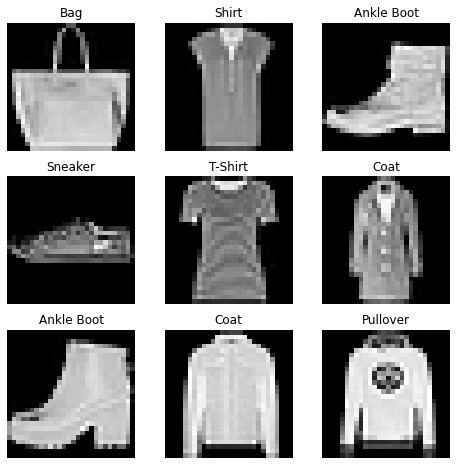

In [23]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [24]:
class NeuralNetwork(nn.Module):
    def __init__(self,n_neurons=512,input_dim=28*28,output_dim=10):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, output_dim),
            
        )
        #self.softmax=nn.Softmax()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        #output=self.softmax(x)  Softmax is not needed only because pytorch does this with cross entropy loss automatically
        return x


In [25]:
learning_rate = 1e-3
batch_size = 64
epochs = 5
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

In [26]:
def fit_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"loss: {loss}  [{current}/{size}]")


def predict_dataset(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Error: \n Accuracy: {(100*correct)}%, Avg loss: {test_loss} \n")
def predict(data,model,apply_softmax=True):
    labels=data[1]
    label=labels[0] #Take first element of batch
    data=data[0]  
    data=data[0,:,:,:] #Take first element of batch
    print(f"Size of one sample is {data.size()}") #First dimension is 1 because image is black & white. Would be 3 for RGB.
    pred = model(data)
    if apply_softmax:
        softmax=nn.Softmax()
        pred=softmax(pred)
    pred=pred.detach().numpy()
    pred=pred[0]
    print(f"Predicted label probabilities for first image: {pred*100}")
    print(f"True label for first image is {label.numpy()}")

In [27]:
weight_decays = [0,0.000001,0.0001,0.1]
for weight_d in weight_decays:
  print(f"Weight decay: {weight_d}")
  model = NeuralNetwork(n_neurons=512)
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_d)
  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      fit_one_epoch(train_dataloader, model, loss_fn, optimizer)
      print('Validation results:')
      predict_dataset(validation_dataloader, model, loss_fn)
  print('Test results:')
  predict(next(iter(test_dataloader)),model,loss_fn)
  predict_dataset(test_dataloader, model, loss_fn)

Weight decay: 0
Epoch 1
-------------------------------
Validation results:
Error: 
 Accuracy: 32.879999999999995%, Avg loss: 2.2156942346293453 

Epoch 2
-------------------------------
Validation results:
Error: 
 Accuracy: 50.83%, Avg loss: 2.094396486403836 

Epoch 3
-------------------------------
Validation results:
Error: 
 Accuracy: 55.669999999999995%, Avg loss: 1.9088207976833271 

Epoch 4
-------------------------------
Validation results:
Error: 
 Accuracy: 57.769999999999996%, Avg loss: 1.6603427411644323 

Epoch 5
-------------------------------
Validation results:
Error: 
 Accuracy: 62.33%, Avg loss: 1.4274982464541295 

Test results:
Size of one sample is torch.Size([1, 28, 28])
Predicted label probabilities for first image: [ 0.8462796  0.5890518  2.1255472  0.8819457  1.8637166  9.4939575
  1.8733008 15.963852  12.681206  53.68114  ]
True label for first image is 9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Error: 
 Accuracy: 62.81%, Avg loss: 1.427103820879748 

Weight decay: 1e-06
Epoch 1
-------------------------------
Validation results:
Error: 
 Accuracy: 38.46%, Avg loss: 2.216551685029534 

Epoch 2
-------------------------------
Validation results:
Error: 
 Accuracy: 50.41%, Avg loss: 2.089153467469914 

Epoch 3
-------------------------------
Validation results:
Error: 
 Accuracy: 59.99%, Avg loss: 1.8846796614349268 

Epoch 4
-------------------------------
Validation results:
Error: 
 Accuracy: 62.0%, Avg loss: 1.6282883715477718 

Epoch 5
-------------------------------
Validation results:
Error: 
 Accuracy: 62.23%, Avg loss: 1.4082372089859787 

Test results:
Size of one sample is torch.Size([1, 28, 28])
Predicted label probabilities for first image: [ 0.55219567  0.34716815  1.7297076   0.45019072  1.4327466   9.409105
  1.3938761  15.446384   13.328585   55.910034  ]
True label for first image is 9
Error: 
 Accuracy: 62.99%, Avg loss: 1.4066739241788342 

Weight decay: 0.00

* Conclusion: Using weight decay 0.0001 improved accuracy compared to no weight decay, however the others performed worse.